In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import os
import sys

In [2]:
# Agregar el directorio al sys.path
base_path = 'C:/Users/Nayeli/Documents/Thesis/'
ruta_module = r'C:\Users\Nayeli\Documents\Thesis\Parameters and functions'
sys.path.append(ruta_module)
import calculate_mortality

In [3]:
scenarios = ['SSP126', 'SSP245', 'SSP370', 'SSP585']
scenarios_SSP = ['SSP1', 'SSP2', 'SSP3', 'SSP5']
years = np.arange(2015,2105,5)
groups = ['oldest', 'older', 'young']
index = pd.MultiIndex.from_product([groups, scenarios], names=['Age group', 'Scenario'])
results_noadapt = pd.DataFrame(index=index, columns=years)
climate_models = ['AWI-CM-1-1-MR','BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1-HR', 'EC-Earth3',
                 'EC-Earth3-Veg', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM', 'TaiESM1']  

## No adaptation and dif. pop growth

In [ ]:
for climate_model in climate_models:
    for group in groups:
        # Read mortality response functions 
        mor_np = calculate_mortality.read_mortality_response(base_path, group)

        for scenario, scenario_SSP in zip(scenarios, scenarios_SSP):
            # Read population files
            POP = pd.read_csv(base_path + f'GDP-POP/POP files/POP_{scenario_SSP}_{group}.csv')
            POP = POP[~POP['hierid'].str.contains('ATA|CA-', regex=True)]
            
            for year in years:
                # Read temperature file
                SSP = pd.read_csv(f'D:/Climate Models - Bias Corrected/{climate_model}/{scenario}/BC_{climate_model}_{scenario}_{year}.csv')
                # Calculate relative mortality per region (deaths/100,000)
                mor_temp = calculate_mortality.calculate_mortality_year(SSP, mor_np)
                mor_temp = mor_temp[~mor_temp['hierid'].str.contains('ATA|CA-', regex=True)]
                # Calculate mortality relative to SSP scenario
                total_mortality = np.sum(POP[f'{year}'].to_numpy() * mor_temp['total_mortality'].to_numpy() / 1e5)
                relative_mortality = total_mortality * 1e5 /np.sum(POP[f'{year}'].to_numpy())
                results_noadapt.at[(group, scenario), year] = relative_mortality
                print(f'{climate_model} - {group} - {scenario} - {year}')

  #  results_noadapt.to_csv(f'No adaptation files - Climate models\\Total mortality_No adaptation_{climate_model}.csv')

## Plot

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
base_path = 'C:\\Users\\Nayeli\\Documents\\Thesis'

In [5]:
colors = {'SSP126': '#5ea7cd', 'SSP245': '#33416b', 'SSP370': '#dd8852', 'SSP585': '#c04242'}
labels = ['2020', '2040', '2060', '2080', '2100']
scenarios = ['SSP126', 'SSP245', 'SSP370', 'SSP585']
decades = ['2015','2020','2025','2030','2035','2040','2045','2050','2055','2060','2065','2070','2075','2080', '2085','2090','2095','2100']
groups = ['Oldest (age > 64 years)', 'Older (5-64 years)', 'Young (age < 5 years)']
climate_models = ['AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1-HR', 'EC-Earth3', 
                  'EC-Earth3-Veg', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM', 'TaiESM1']  
dataframes = {}
for climate_model in climate_models:
    file_path = f'No adaptation files - Climate models/Total mortality_No adaptation_{climate_model}.csv'
    dataframes[climate_model] = pd.read_csv(file_path, index_col=[0,1])

In [6]:
index = pd.MultiIndex.from_product([groups, scenarios], names=['Age group', 'Scenario'])
average = pd.DataFrame(index=index, columns=decades)
stdev = pd.DataFrame(index=index, columns=decades)

for i in np.arange(0,12):
    for j in range(len(decades)):
        a = []
        for climate_model in climate_models:
            a.append(dataframes[climate_model].iloc[i,j])
        average.iloc[i,j] = np.mean(a)
        stdev.iloc[i,j] = 2*np.std(a)

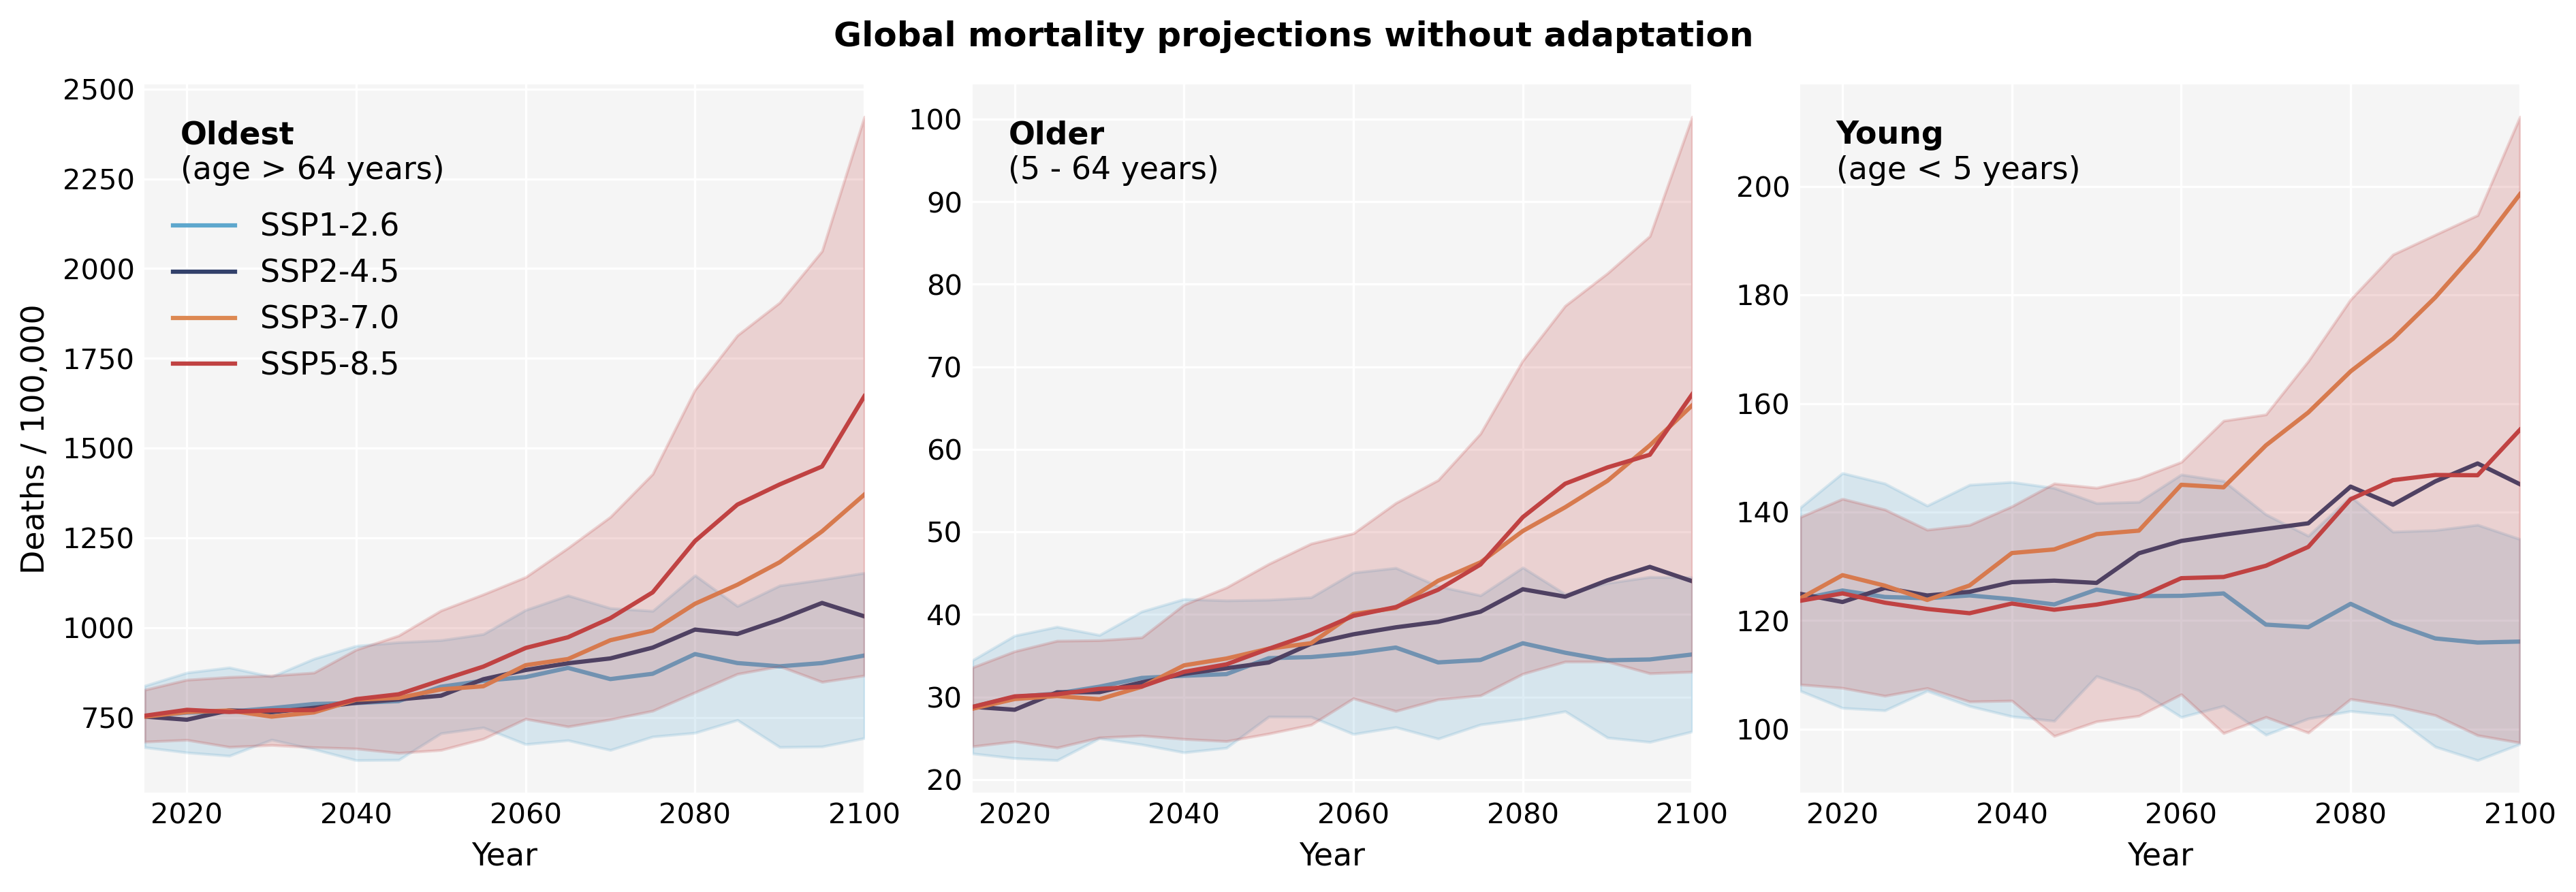

In [7]:
text_groups = ['Oldest', 'Older', 'Young']
text_groups2 = ['(age > 64 years)', '(5 - 64 years)', '(age < 5 years)']
legends = ['SSP1-2.6', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']

plt.figure(figsize=(15, 4.5), dpi=300)
plt.subplots_adjust(wspace=0.15)

for i, group in enumerate(groups, start=1):
    ax = plt.subplot(1, 3, i)
    group_data = average.xs(group, level='Age group')
    group_std = stdev.xs(group, level='Age group') 
    
    for j,scenario in enumerate(scenarios):
        mean_line = group_data.loc[scenario].astype(float)
        std_line = group_std.loc[scenario].astype(float)
        ax.plot(decades, mean_line, label=legends[j], color=colors[scenario], lw=1.5)
        if scenario == 'SSP126' or scenario == 'SSP585':
            ax.fill_between(decades, mean_line - std_line, mean_line + std_line, color=colors[scenario], alpha=0.2, zorder=2)

    ax.set_xlabel('Year', fontsize=11)
    ax.set_xlim('2015', '2100')
    if i==1:
        ax.set_ylabel('Deaths / 100,000', fontsize=11)
        ax.legend(fontsize=11, loc='center left', bbox_to_anchor=(0, 0.7), frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, color='white', zorder=0)
    ax.set_facecolor('whitesmoke')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', length=0)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    ax.text(0.05, 0.95, text_groups[i-1], transform=ax.transAxes, verticalalignment='top', fontsize=11, weight='bold')
    ax.text(0.05, 0.9, text_groups2[i-1], transform=ax.transAxes, verticalalignment='top', fontsize=11)

plt.suptitle('Global mortality projections without adaptation', fontsize=12, y=0.95, weight='bold')
# plt.savefig(os.path.join(base_path, 'Figures\\Fig_Mortality_Global_NoAdap.pdf'), bbox_inches='tight', dpi=300)
plt.savefig(os.path.join(base_path, 'Figures\\450 dpi\\Fig_Mortality_Global_NoAdap.png'), bbox_inches='tight', dpi=450)
plt.savefig(os.path.join(base_path, 'Figures\\600 dpi\\Fig_Mortality_Global_NoAdap.png'), bbox_inches='tight', dpi=600)
plt.show()

## No adaptation - Assuming same population SSP1,2,3,4,5 

In [18]:
scenario_SSP = 'SSP2'

for climate_model in climate_models:
    for group in groups:
        # Read mortality response functions 
        mor_np = calculate_mortality.read_mortality_response(base_path, group)
         # Read population files
        POP = pd.read_csv(base_path + f'GDP-POP/POP files/POP_{scenario_SSP}_{group}.csv')
        POP = POP[~POP['hierid'].str.contains('ATA|CA-', regex=True)]

        for scenario in scenarios:
            for year in years:
                # Read temperature file
                SSP = pd.read_csv(f'D:/Climate Models - Bias Corrected/{climate_model}/{scenario}/BC_{climate_model}_{scenario}_{year}.csv')
                # Calculate relative mortality per region (deaths/100,000)
                mor_temp = calculate_mortality.calculate_mortality_year(SSP, mor_np)
                mor_temp = mor_temp[~mor_temp['hierid'].str.contains('ATA|CA-', regex=True)]
                # Calculate mortality relative to SSP scenario
                total_mortality = np.sum(POP[f'{year}'].to_numpy() * mor_temp['total mortality'].to_numpy() / 1e5)
                relative_mortality = total_mortality * 1e5 /np.sum(POP[f'{year}'].to_numpy())
                results_noadapt.at[(group, scenario), year] = relative_mortality
                print(f'{climate_model} - {group} - {scenario} - {year}')

    results_noadapt.to_csv(f'No adaptation files - Climate models\\Total mortality_No adaptation_SSP2_{climate_model}.csv')

AWI-CM-1-1-MR - oldest - SSP126 - 2015
AWI-CM-1-1-MR - oldest - SSP126 - 2020
AWI-CM-1-1-MR - oldest - SSP126 - 2025
AWI-CM-1-1-MR - oldest - SSP126 - 2030
AWI-CM-1-1-MR - oldest - SSP126 - 2035
AWI-CM-1-1-MR - oldest - SSP126 - 2040
AWI-CM-1-1-MR - oldest - SSP126 - 2045
AWI-CM-1-1-MR - oldest - SSP126 - 2050
AWI-CM-1-1-MR - oldest - SSP126 - 2055
AWI-CM-1-1-MR - oldest - SSP126 - 2060
AWI-CM-1-1-MR - oldest - SSP126 - 2065
AWI-CM-1-1-MR - oldest - SSP126 - 2070
AWI-CM-1-1-MR - oldest - SSP126 - 2075
AWI-CM-1-1-MR - oldest - SSP126 - 2080
AWI-CM-1-1-MR - oldest - SSP126 - 2085
AWI-CM-1-1-MR - oldest - SSP126 - 2090
AWI-CM-1-1-MR - oldest - SSP126 - 2095
AWI-CM-1-1-MR - oldest - SSP126 - 2100
AWI-CM-1-1-MR - oldest - SSP245 - 2015
AWI-CM-1-1-MR - oldest - SSP245 - 2020
AWI-CM-1-1-MR - oldest - SSP245 - 2025
AWI-CM-1-1-MR - oldest - SSP245 - 2030
AWI-CM-1-1-MR - oldest - SSP245 - 2035
AWI-CM-1-1-MR - oldest - SSP245 - 2040
AWI-CM-1-1-MR - oldest - SSP245 - 2045
AWI-CM-1-1-MR - oldest - 

## Plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
base_path = 'C:\\Users\\Nayeli\\Documents\\Thesis'

In [2]:
colors = {'SSP126': '#5ea7cd', 'SSP245': '#33416b', 'SSP370': '#dd8852', 'SSP585': '#c04242'}
labels = ['2020', '2040', '2060', '2080', '2100']
scenarios = ['SSP126', 'SSP245', 'SSP370', 'SSP585']
decades = ['2015','2020','2025','2030','2035','2040','2045','2050','2055','2060','2065','2070','2075','2080', '2085','2090','2095','2100']
groups = ['Oldest (age > 64 years)', 'Older (5-64 years)', 'Young (age < 5 years)']
climate_models = ['AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1-HR', 'EC-Earth3',
                  'EC-Earth3-Veg', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM', 'TaiESM1']  
dataframes = {}
for climate_model in climate_models:
    file_path = f'No adaptation files - Climate models/Total mortality_No adaptation_SSP2_{climate_model}.csv'
    dataframes[climate_model] = pd.read_csv(file_path, index_col=[0,1])

In [3]:
index = pd.MultiIndex.from_product([groups, scenarios], names=['Age group', 'Scenario'])
average = pd.DataFrame(index=index, columns=decades)
stdev = pd.DataFrame(index=index, columns=decades)

for i in np.arange(0,12):
    for j in range(len(decades)):
        a = []
        for climate_model in climate_models:
            a.append(dataframes[climate_model].iloc[i,j])
        average.iloc[i,j] = np.mean(a)
        stdev.iloc[i,j] = 2*np.std(a)

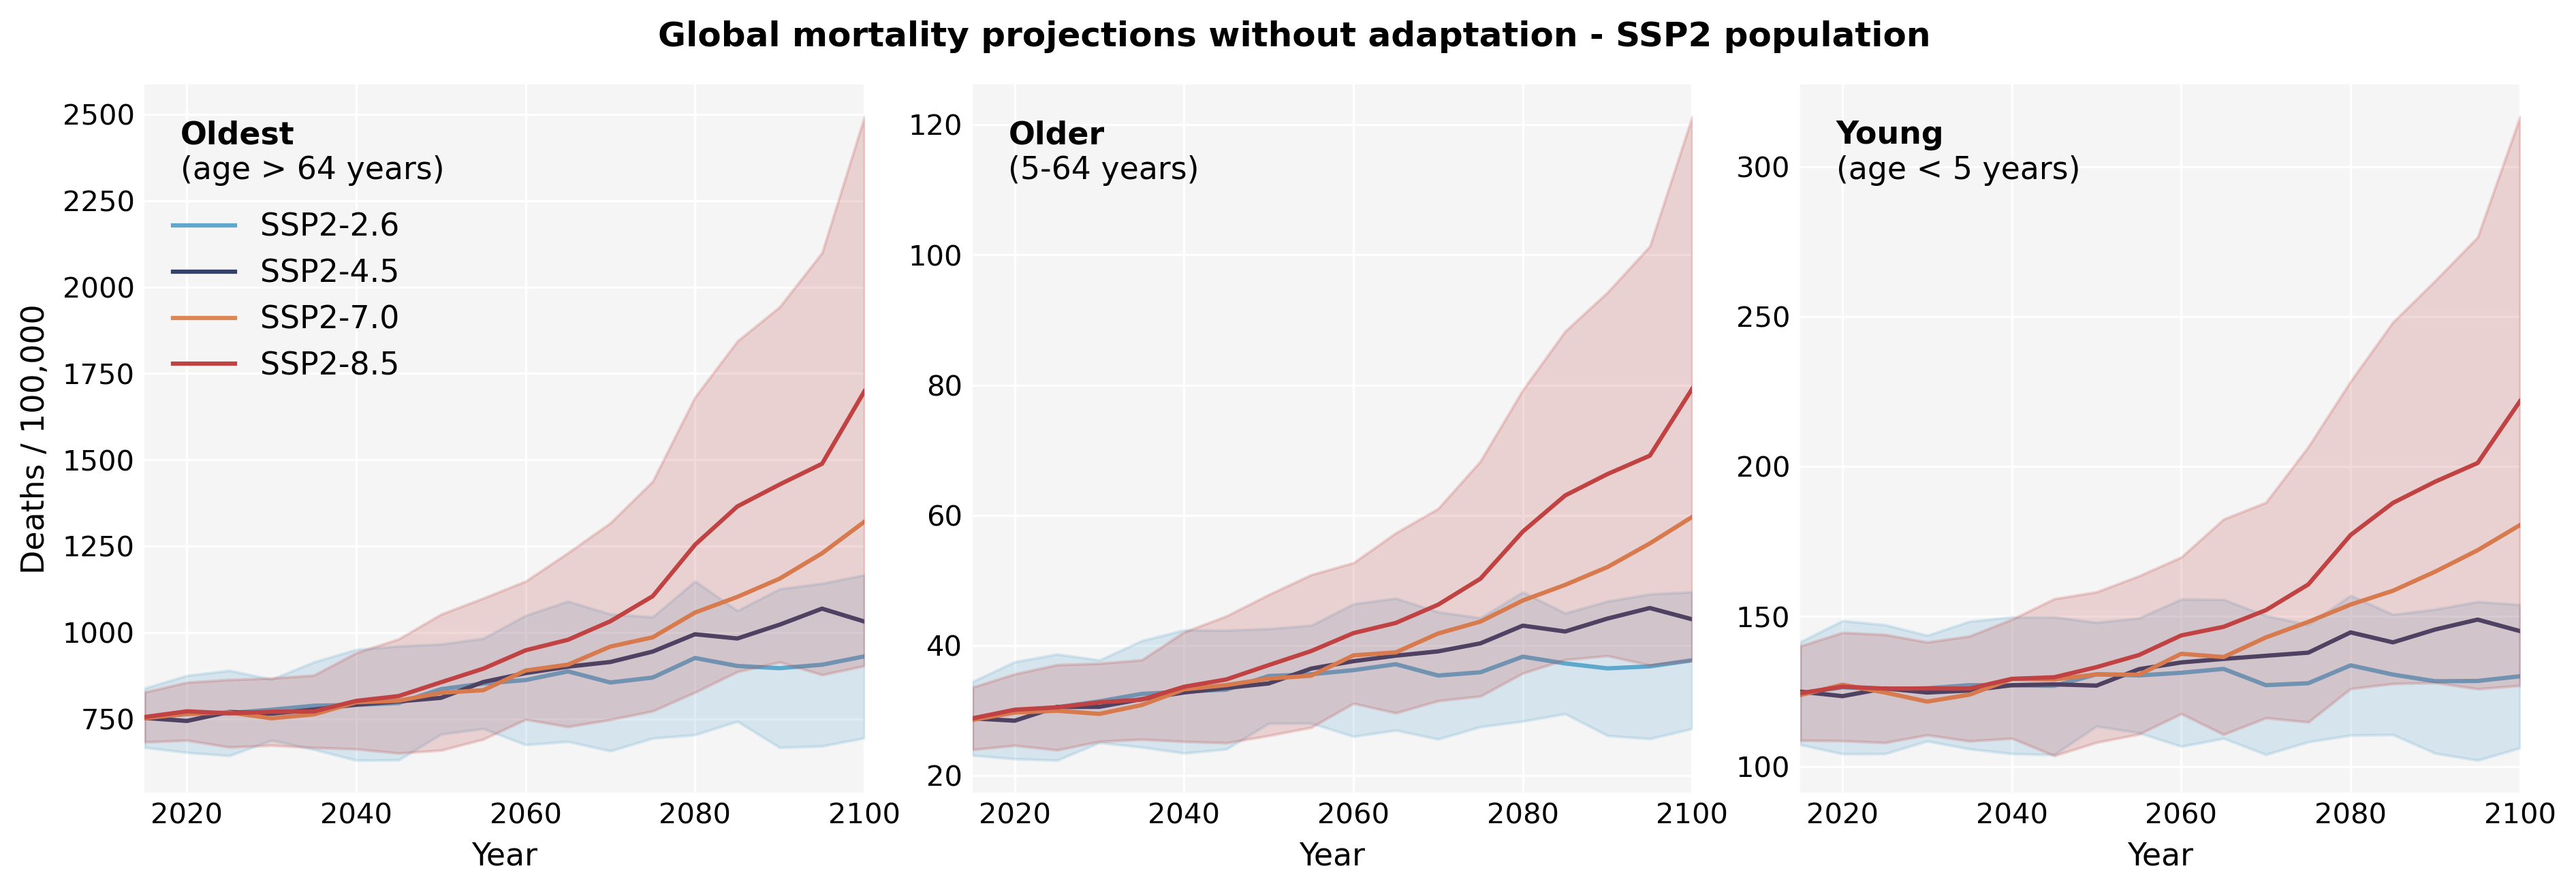

In [5]:
text_groups = ['Oldest', 'Older', 'Young']
text_groups2 = ['(age > 64 years)', '(5-64 years)', '(age < 5 years)']
legends = ['SSP2-2.6', 'SSP2-4.5', 'SSP2-7.0', 'SSP2-8.5']

plt.figure(figsize=(15, 4.5), dpi=300)
plt.subplots_adjust(wspace=0.15)

for i, group in enumerate(groups, start=1):
    ax = plt.subplot(1, 3, i)
    group_data = average.xs(group, level='Age group')
    group_std = stdev.xs(group, level='Age group') 
    
    for j,scenario in enumerate(scenarios):
        mean_line = group_data.loc[scenario].astype(float)
        std_line = group_std.loc[scenario].astype(float)
        ax.plot(decades, mean_line, label=legends[j], color=colors[scenario], lw=1.5)
        if scenario == 'SSP126' or scenario == 'SSP585':
            ax.fill_between(decades, mean_line - std_line, mean_line + std_line, color=colors[scenario], alpha=0.2, zorder=2)

    ax.set_xlabel('Year', fontsize=11)
    ax.set_xlim('2015', '2100')
    if i==1:
        ax.set_ylabel('Deaths / 100,000', fontsize=11)
        ax.legend(fontsize=11, loc='center left', bbox_to_anchor=(0, 0.7), frameon=False)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True, color='white', zorder=0)
    ax.set_facecolor('whitesmoke')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='y', length=0)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    ax.text(0.05, 0.95, text_groups[i-1], transform=ax.transAxes, verticalalignment='top', fontsize=11, weight='bold')
    ax.text(0.05, 0.9, text_groups2[i-1], transform=ax.transAxes, verticalalignment='top', fontsize=11)

plt.suptitle('Global mortality projections without adaptation - SSP2 population', fontsize=12, y=0.95, weight='bold')
plt.savefig(os.path.join(base_path, 'Figures\\Fig_Mortality_Global_NoAdap_SSP2.png'), bbox_inches='tight', dpi=300)
plt.show()